In [4]:
# Importing libraries

from matplotlib import pyplot as plt
import cv2
import numpy as np
import os
import random
import shutil
from PIL import Image

x_dim = 32
y_dim = 32

In [5]:
# Splitting the dataset into train and test folders. Please create test and train dir in the given path before running this.

def delete_contents(folder): # function to delete the files in a dir
    if not os.path.exists(folder): # if path doesn't exist, the folder is created
            os.makedirs(folder)
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

def get_files_from_folder(path): #Returns all the files and folders in a given path.

    files = os.listdir(path)
    return np.asarray(files)

def main(path_to_data, path_to_test_data, path_to_train_data, train_ratio):
    # get dirs
    _, dirs, _ = next(os.walk(path_to_data))

    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_data, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))
    train_counter = np.round(data_counter_per_class * train_ratio)

    # transfers files
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_data, dirs[i])

        #creates dir
        if not os.path.exists(path_to_test_data):
            os.makedirs(path_to_test_data)
        if not os.path.exists(path_to_train_data):
            os.makedirs(path_to_train_data)
            
        files = get_files_from_folder(path_to_original)
        random.shuffle(files)
        # moves data
        for j in range(int(test_counter[i])):
            dst = os.path.join(path_to_test_data, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.copy(src, dst)
        #files = get_files_from_folder(path_to_original)
        #random.shuffle(files)
        for j in range(int(test_counter[i]),len(files)):
            dst = os.path.join(path_to_train_data, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.copy(src, dst)
            
if __name__ == "__main__":
    delete_contents('./train')
    delete_contents('./test')
    main('./Images_face95','./test','./train',0.7)

In [6]:
# Path for the training images

Path = './train/'
files = os.listdir(Path)
files.sort()

In [7]:
# Converting each image to Grayscale and appending the data to images

images = []

for name in files:
    temp = cv2.imread('./train/'+name)
    temp = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
    temp = cv2.resize(temp, (x_dim,y_dim), interpolation = cv2.INTER_AREA)
    images.append(temp.flatten())
        
# let total number of train images be : m

# images : rows - m
#          columns - 32*32 = 1024
# images.shape : (m,1024)

# temp.shape : (32, 32)

In [8]:
# Calculating the mean of images

images = np.array(images)
image_mean = images.mean(axis = 0)

# Subtracting mean of images from the train images
images = images - image_mean

# transpose of images taken to find eigen vectors of covariance matrix - AA'
images = images.T

# image_mean.shape : (1024,)
# images.shape : (1024, m)

In [9]:
# REPORT
# Saving 4 sample difference faces

h = []
for i in random.sample(range(images.shape[1]),4):
    reshape = np.reshape(images[:,i], (32, 32))
    new_p = Image.fromarray(reshape) # unflattening the image
    new_p = new_p.convert("L")       #convert to grayscale image.
    new_p = np.array(new_p)          # making numpy array
    new_p= cv2.copyMakeBorder(new_p,3,3,3,3,cv2.BORDER_CONSTANT,value=[255,255,255]) #adding the padding to the images.
    h.append(new_p)             #adding the images to a list
    
# storing the images side-by-side
def type1(a,b,c,d):
    g = np.concatenate((a,b),axis = 1) #concatenating them
    i = np.concatenate((c,d),axis = 1) #concatenating them
    cv2.imwrite("difference_faces.jpg",np.concatenate((g,i),axis = 1)) #concatenating them and saving

type1(*h)

In [10]:
# Saving the image mean

reshape = np.reshape(image_mean, (32, 32))
new_p = Image.fromarray(reshape)
new_p = new_p.convert("L")
new_p = np.array(new_p)
cv2.imwrite("image_mean.jpg",new_p)

True

In [11]:
#SVD function
#u is the basis of eigen faces

u,s,v = np.linalg.svd(images, full_matrices=False)

# assuming rank to be - m, we consider only first m eigen vectors
# u.shape : (1024, m)
# There are m eigen faces currently

In [12]:
# Calculating the number of singular values required for obtaining 90% of the sum of singular values

su = 0
for i in range(len(s)):
    if(su>(0.90*np.sum(s))):
        break;
    su+=s[i]
    
print(i)
#The number obtained is pretty high and there is no substantial increase in the accuracy.

364


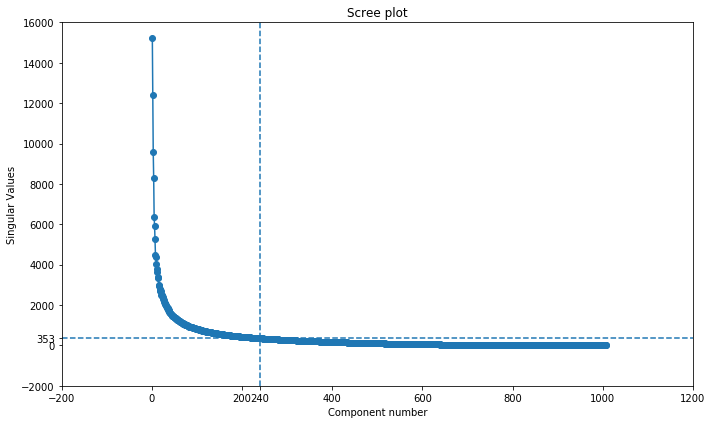

In [13]:
# Plotting a scree plot
x1 = range(1,s.shape[0]+1)
y1 = s

#Plot a line graph
fig, ax1 = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(x1, y1, marker='o')
ax1.axhline(y=s[240], xmin=0, xmax=images.shape[1], ls='--')
ax1.axvline(x=240, ymin=0, ymax=s[240], ls='--')
x_ticks = np.append(ax1.get_xticks(), 240)
y_ticks = np.append(ax1.get_yticks(), s[240])
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_title("Scree plot")
ax1.set(xlabel="Component number",ylabel="Singular Values")

fig.tight_layout()
plt.show()

In [14]:
# dropping the unwanted columns in U matrix to form the feature matrix.

u = u[:,:240]

In [15]:
# Dot product of all the images and U matrix to find the projection co-efficients

dot_train = np.empty(shape = (u.shape[1], images.shape[1]),  dtype=np.int8)
temp = np.empty(shape = (1, u.shape[1]),  dtype=np.int8)

# u.shape : (m, 240)
# images.shape : (1024, m)
# dot_train.shape : (240, m)
# temp.shape : (1, 240)

for i in range(images.shape[1]):    # i from 0 to m
    for c in range(u.shape[1]):    # c from 0 to 240
        temp[0,c] = np.sum(images[:,i] * u[:,c])
        
    dot_train[:, i] = temp[:]

In [16]:
# REPEAT THE EXECUTION OF CODE BELOW FOR NEW INPUT

In [17]:
# Path for the testing images

Path = './test/'
tfiles = os.listdir(Path)
tfiles.sort()

In [18]:
# Converting test images to Grayscale and appending them to test_images

test_images = []

for name in tfiles:
    temp = cv2.imread('./test/'+name)
    temp = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
    temp = cv2.resize(temp, (x_dim,y_dim), interpolation = cv2.INTER_AREA)
    test_images.append(temp.flatten())       
    
# let total number of train images be : t

# test_images : rows - t
#          columns - 32*32 = 1024
# test_images.shape : (t,1024)

# temp.shape : (32, 32)

In [19]:
# Substracting mean from test_images

test_images = np.array(test_images)
test_images = test_images - image_mean
test_images = test_images.T

In [20]:
# Dot product of test image and U matrix

dot_test = np.empty(shape = (u.shape[1], test_images.shape[1]), dtype=np.int8)
temp = np.empty(shape = (1, u.shape[1]),  dtype=np.int8)

# u.shape : (t, 240)
# test_images.shape : (1024, t)
# dot_train.shape : (240, t)
# temp.shape : (1, 240)
    
for i in range(test_images.shape[1]):    # i from 0 to t
    for c in range(u.shape[1]):          # c from 0 to 240
        temp[0,c] = np.sum(test_images[:,i] * u[:,c])
        
    dot_test[:, i] = temp[:]

In [21]:
# calculating the variation between input image and test images

answer = np.empty(shape=(dot_train.shape[1],dot_test.shape[1]))
# answer.shape : (m, t)

for i in range(dot_test.shape[1]): # i from 0 to m
    
    sub = np.empty(shape = (u.shape[1], dot_train.shape[1]), dtype=np.int8)
    # sub.shape : (240, m)
    
    # subtracting the points to calculate variation
    for col in range(dot_train.shape[1]): # col from 0 to t
        sub[:,col] = dot_train[:,col] - dot_test[:,i]
    
    # calculating the magnitude of distance
    for c in range(sub.shape[1]): # c from 0 to m
        answer[c,i] = np.linalg.norm(sub[:,c])
        

In [22]:
def min_index(temp):
    m = 0
    for i in range(len(temp)):
        if temp[i]<temp[m]:
            m = i
    return m

In [23]:
# FACE RECOGNITION

temp_ans = np.empty(shape=(answer.shape[1],),dtype=int)
temp = np.empty(shape=(answer.shape[0],))

# temp_ans.shape : (t, )
# temp.shape : (m, )

# calculating the nearest face in the train dataset
for i in range(0,answer.shape[1]):
    temp = answer[:,i]
    temp_ans[i] = min_index(temp)

In [24]:
unmatched = [] # list of unmatched faces
right = 0 # number of matched faces
total = test_images.shape[1] # total number of faces = t

for i in range(temp_ans.shape[0]):
    
    # if file_name matches with the test_image name, it has been matches correctly
    if tfiles[i].split(".")[0] == files[temp_ans[i]].split(".")[0]:
        right+=1
    
    # else, it is incorrectly matched
    else:
        unmatched.append(" ".join((tfiles[i].split(".")[0],files[temp_ans[i]].split(".")[0],str(temp_ans[i]))))
        
acc = (right/total)*100
print("Accuracy: ",acc,"%\n")

print("Face that matched incorrectly:")
for i in unmatched:
    print("\t",i)

Accuracy:  85.18518518518519 %

Face that matched incorrectly:
	 adhast matth 530
	 ajbake namart 589
	 apapou gstamo 269
	 apdavi matth 528
	 apdavi kouri 459
	 apdavi riphil 750
	 awjsud namart 596
	 bschap kouri 458
	 bschap matth 528
	 cadugd gstamo 269
	 cadugd pajaco 639
	 cdlarg matth 526
	 cdlarg namart 600
	 cdlarg ldgodd 485
	 cfloro mkosto 572
	 cywan virvi 991
	 dakram namart 598
	 dakram sherbe 812
	 darda theoc 921
	 dfhodd ardper 63
	 dgemen sjpalm 883
	 gsmall namart 598
	 gstamo matth 529
	 gstamo matth 518
	 gsvird hsgrim 331
	 howar lidov 501
	 jross virvi 992
	 jserai sdwall 791
	 jserai cfloro 153
	 jserai sapere 772
	 jserai ardper 63
	 jshea jbierl 373
	 jshea kmbald 442
	 kmbald cfloro 140
	 kouri matth 521
	 llambr cywan 179
	 matth namart 598
	 mdchud pcfry 668
	 mizli thgear 945
	 mrhami ldgodd 487
	 ogefen dgemen 249
	 ogefen sherbe 818
	 papad jbierl 366
	 papad sherbe 812
	 pcfry ardper 57
	 pears virvi 988
	 pears awjsud 80
	 pears awjsud 81
	 rhnorm nama

In [25]:
# REPORT
# Saving sample test cases and their outputs.

position = (9,9) # position of the text on the image (25,30) incase of 100 by 100
count = 0
h = []
v = []
for i in random.sample(range(test_images.shape[1]),4): #we sample 4 random images from the images matrix
    reshape = np.reshape(test_images[:,i], (32, 32)) #input face
    oreshape = np.reshape(images[:,temp_ans[i]], (32, 32)) #output face
    new_p = Image.fromarray(reshape) #reshaping the input face
    new_p = new_p.convert("RGB") #convert to RGB image. It will be still grayscale, but this is done to add the colored text
    new_p = np.array(new_p) #making numpy array
    new_p= cv2.copyMakeBorder(new_p,3,3,5,2,cv2.BORDER_CONSTANT,value=[255,255,255]) #making a white border 10,10,15,5 incase of 100 by 100
    new_f = Image.fromarray(oreshape) #reshaping the output face
    new_f = new_f.convert("RGB") #convert to RGB image. It will be still grayscale, but this is done to add the colored text
    new_f = np.array(new_f)#making numpy array
    new_f= cv2.copyMakeBorder(new_f,3,3,2,5,cv2.BORDER_CONSTANT,value=[255,255,255])#making a white border 10,10,5,15 incase of 100 by 100
    #this is for adding the predicted name onto the output face
    cv2.putText(new_f, files[temp_ans[i]].split(".")[0], position, cv2.FONT_HERSHEY_SIMPLEX,0.16, (255, 255, 255), 1, cv2.LINE_AA) #0.5 instead of 0.16 incase of 100 by 100
    h.append(np.concatenate((new_p, new_f),axis = 1)) #appending the 4 input-output images to a list

def type1(a,b,c,d):
    g = np.concatenate((a,b),axis = 1) #concatenating two images horizontally.
    i = np.concatenate((c,d),axis = 1) #concatenating two images horizontally.
    cv2.imwrite("Sample.jpg",np.concatenate((g,i),axis = 0)) #concatenating two images vertically and saving it.

type1(*h)